In [1]:
def combine_predict(input_mask, origin_shape, config):
    """ combine and resample mask
    :param input_mask: [n,s,h,w] (n,32,384,384) or (n,64,128,128)
    :param config: train config
    :param z_thick: [s,h,w]
    :return: origin mask
    """
    voxel_z = origin_shape[0]
    target_gen_size = config.layer_thick
    range_val = int(math.ceil((voxel_z - target_gen_size) / config.stride) + 1)
    combine_masks = torch.zeros(origin_shape, dtype=torch.int8)

    for i in range(range_val):
        start_num = i * config.stride
        end_num = start_num + target_gen_size
        if end_num <= voxel_z:
            # 数据块长度没有超出x轴的范围,正常取块
            combine_masks[start_num:end_num, :, :] = torch.from_numpy(
                cv2.bitwise_or(np.array(combine_masks[start_num:end_num, :, :]),
                               np.array(input_mask[range_val])))
        else:
            # 数据块长度超出x轴的范围, 从最后一层往前取一个 batch_gen_size 大小的块作为本次获取的数据块
            combine_masks[(voxel_z - target_gen_size):voxel_z, :, :] = torch.from_numpy(cv2.bitwise_or(
                np.array(combine_masks[(voxel_z - target_gen_size):voxel_z, :, :]),
                np.array(input_mask[range_val])))
    return combine_masks



In [2]:

import torch
from utils.config import Config, CoarseConfig
from utils.message import Msg
from utils.validation import Validation, get_cube, combine_image
from net.ResUnet import ResNetUNet
from utils.save import Save
from utils.convert import Convert
from utils.visualization import show_views
import numpy as np
from net.ResUnet_3D import UNet3D
import math
import cv2
from utils.data_utils import get_area, crop_area, z_resample
from utils.metrics import compute_metrics_for_label
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME


msg = Msg()
config = Config()
coarse_config = CoarseConfig()
validation = Validation()
convert_file = Convert()
save = Save()

# model = UNet(n_channels=1, classes=2)
config.first_model = f"./ResNetUNet-3D_conv_coarse_True_Adam_0/CP_epoch7.pth"
model1 = UNet3D()
model1.load_state_dict(torch.load(config.first_model,
                                  map_location=config.device))
model1.to(device=config.device)

# raw image root
image_root = "/public/home/cxiao/Study/data/kits21/image/case_00285.nii.gz"
mask_root = "/public/home/cxiao/Study/data/kits21/mask/case_00285.nii.gz"
# image_root = "/public/datasets/kidney/kits19/kits19/data/case_00001/imaging.nii.gz"
# mask_root = "/public/datasets/kidney/kits19/kits19/data/case_00001/segmentation.nii.gz"
patient_name = ""
images_numpy, origin_spacing = convert_file.select(image_root)
ground_t, origin_spacing = convert_file.select(mask_root)
print(images_numpy.shape)
first_masks, crop_image, new_spacing, z_thick = validation.predict_all(model1, images_numpy, config, origin_spacing)
msg.norm("masks len", len(first_masks))
# combine slices mask to n,384,384(re_sample):
masks_list = list()
for i in range(len(first_masks)):
    masks_list.append(first_masks[i])
first_pre_masks = torch.vstack(masks_list)
first_pre_masks = torch.vstack(masks_list)[:len(crop_image), :, :]
print(first_pre_masks.shape, origin_spacing)
# coarse network-----------------------------------------


(41, 512, 512)


/public/home/cxiao/Study/git_pro/kits20_xcd/utils/validation.py:389: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(case_pred, dtype=torch.int8), images, new_spacing, z_thick
INFO: masks len:4


torch.Size([102, 384, 384]) [5.        0.6503906 0.6503906]


In [3]:
import cv2
print(cv2.__version__)

4.5.3


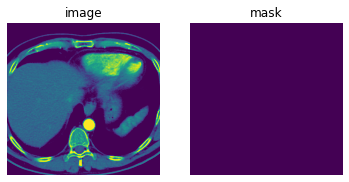

torch.Size([102, 384, 384])


In [4]:
first_pre_masks = torch.vstack(masks_list)[:len(crop_image), :, :]
index = 10
show_views(crop_image[index],first_pre_masks[index])
print(first_pre_masks.shape)

In [5]:
def padding(target_size, input_size):
    pad_1 = (target_size - input_size) // 2
    pad_2 = (target_size - input_size) / 2
    if pad_1 != pad_2:
        pad_2 = pad_1 + 1
    else:
        pad_2 = pad_1

    return (pad_1, pad_2)


In [6]:
# fine network-----------------------------------------
config.second_model = f"./ResNetUNet-3D_conv_coarse_False_Adam1629645870.053776_0/CP_epoch7.pth"
model2 = UNet3D()
model2.load_state_dict(torch.load(config.second_model,
                                  map_location=config.device))
model2.to(device=config.device)
# ______________________________ get kidney area
first_pre_masks_copy = first_pre_masks.clone()
first_pre_masks_copy[first_pre_masks_copy > 1] = 1
kidney_area = get_area(first_pre_masks_copy)
if len(kidney_area) >= 2:
    kidney_area = kidney_area[:2]
else:
    kidney_area = kidney_area[0]
# predict
final_mask = torch.zeros_like(crop_image, dtype=torch.int8)

for i in range(len(kidney_area)):
    crop_img, crop_mask, _, crop_edge = crop_area(crop_image, first_pre_masks, kidney_area[i],
                                                  coarse_config.area_size)
#     save.save_2_nii(crop_mask,config.save_path,str(i))
#     save.save_2_nii(crop_img, config.save_path, str(i)+"image")
    second_masks, _, spacing, _ = validation.predict_all(model2, crop_img, coarse_config)
    # b*64*128*128 -> n*128*128
    # second_pre_masks = combine_image(second_masks, crop_img.shape, coarse_config)
    second_pre_masks = list()
    for i in range(len(second_masks)):
        second_pre_masks.append(second_masks[i])
    second_pre_masks = torch.vstack(second_pre_masks)[:len(crop_img), :, :]

    assert crop_img.shape != second_pre_masks, "difference shape between crop img and pre mask"
    # combine 64*128*128 to s*384*384
    final_mask[crop_edge[0]:crop_edge[3], crop_edge[1]:crop_edge[4], crop_edge[2]:crop_edge[5]] = second_pre_masks

# n*384*384 to n1*512*512
pad_x = padding(config.resize_xy[0],config.crop_xy[0])
pad_y = padding(config.resize_xy[1], config.crop_xy[1])
final_mask = np.pad(final_mask, ((0, 0), pad_x, pad_y), 'minimum')
final_mask_resample,_ = z_resample(final_mask, new_spacing, re_thickness=origin_spacing[0], re_xy=config.resize_xy)
print("out :",final_mask_resample.shape)
if final_mask_resample.shape[0] < ground_t.shape[0]:
    p = ground_t.shape[0] - final_mask_resample.shape[0]
    final_mask_resample = np.pad(final_mask_resample, ((0, p), (0, 0), (0, 0)), 'minimum')
else:
    final_mask_resample = final_mask_resample[:ground_t.shape[0], :, :]
 

out : (41, 512, 512)


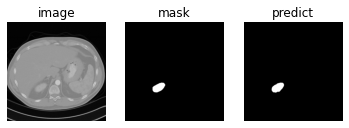

3


In [7]:
index=10
show_views(images_numpy[index],ground_t[index],final_mask_resample[index], cmap="gray")
print(ground_t.max())

In [17]:
from utils.data_utils import save_nii
metrics_case = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
for i, hec in enumerate(HEC_NAME_LIST):
    metrics_case[i] = compute_metrics_for_label(final_mask_resample, ground_t,
                                                KITS_HEC_LABEL_MAPPING[hec],
                                                tuple(origin_spacing),
                                                sd_tolerance_mm=HEC_SD_TOLERANCES_MM[hec])
msg.norm("dice and sds", metrics_case)
# save.save_2_nii(final_mask_resample,config.save_path, patient_name="mask")
print(origin_spacing)
save_nii(config.save_path, final_mask_resample, np.array([origin_spacing[2],origin_spacing[1],origin_spacing[0]]).tolist(), "mask.nii.gz")

INFO: dice and sds:[[0.92877955 0.7908742 ]
 [0.01814059 0.03036488]
 [0.         0.        ]]


[5.        0.6503906 0.6503906]


In [29]:
image_root = "/public/home/cxiao/Study/data/kits21/image/case_00289.nii.gz"
mask_root = "/public/home/cxiao/Study/data/kits21/mask/case_00277.nii.gz"
# image_root = "/public/datasets/kidney/kits19/kits19/data/case_00001/imaging.nii.gz"
# mask_root = "/public/datasets/kidney/kits19/kits19/data/case_00001/segmentation.nii.gz"
patient_name = ""
images_numpy, origin_spacing = convert_file.select(image_root)
ground_t, origin_spacing = convert_file.select(mask_root)
print(images_numpy.max(), images_numpy.min())

2983.0 -1024.0


In [52]:
index = 20

show_views(images_numpy[index], ground_t[index], first_masks[index], cmap="gray")

IndexError: index 20 is out of bounds for dimension 0 with size 7

In [ ]:
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
print(validation.calculate_metrics(first_masks, ground_t,spacing))
print(first_masks.shape)


In [34]:
save.save_2_nii(first_masks.float(), save_path=config.save_path,
                patient_name="kidney")

INFO: info:save nii


In [26]:
crop_info = get_crop_info(images_numpy,first_masks)
print(torch.from_numpy(images_numpy).shape, first_masks.shape)
print(crop_info)

torch.Size([93, 512, 512]) torch.Size([93, 512, 512])
[{'slice': 10, 'patch_count': 0, 'bbox': [95, 351, 241, 497]}, {'slice': 10, 'patch_count': 1, 'bbox': [106, 362, 234, 490]}, {'slice': 11, 'patch_count': 0, 'bbox': [129, 385, 253, 509]}, {'slice': 17, 'patch_count': 0, 'bbox': [239, 495, 192, 448]}, {'slice': 17, 'patch_count': 1, 'bbox': [249, 505, 203, 459]}, {'slice': 19, 'patch_count': 0, 'bbox': [198, 454, 58, 314]}, {'slice': 19, 'patch_count': 1, 'bbox': [206, 462, 52, 308]}, {'slice': 20, 'patch_count': 0, 'bbox': [195, 451, 59, 315]}, {'slice': 23, 'patch_count': 0, 'bbox': [203, 459, 28, 284]}, {'slice': 24, 'patch_count': 0, 'bbox': [203, 459, 28, 284]}, {'slice': 25, 'patch_count': 0, 'bbox': [201, 457, 27, 283]}, {'slice': 25, 'patch_count': 1, 'bbox': [228, 484, 222, 478]}, {'slice': 25, 'patch_count': 2, 'bbox': [136, 392, 112, 368]}, {'slice': 25, 'patch_count': 3, 'bbox': [139, 395, 114, 370]}, {'slice': 26, 'patch_count': 0, 'bbox': [199, 455, 25, 281]}, {'slice'

In [27]:
# --------------------------------------------------------- second network--------------------

crop_images, crop_masks = get_cube(torch.from_numpy(images_numpy).unsqueeze(dim=1),
                                   first_masks.unsqueeze(dim=1),crop_info)

print(crop_images.shape)
config.second_model = f"./ResNetUNet_sec_True_aug_Adam_0/CP_epoch16.pth"
model2 = ResNetUNet(in_channel=1, classes=4)
model2.load_state_dict(torch.load(config.first_model,
                                  map_location=config.device))
model2.to(device=config.device)
second_masks = validation.predict_all(model2, BaseDataset.preprocess(crop_images), config)


torch.Size([88, 1, 256, 256])


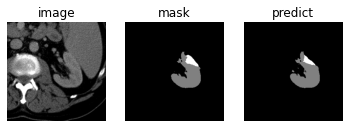

[93, 1, 512, 512]
(93, 1, 512, 512)


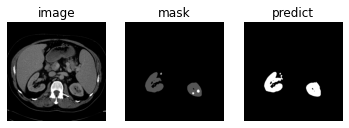

INFO: info:save nii


In [28]:
show_views(crop_images[39][0], crop_masks[39][0], second_masks[39], cmap="gray")
fina_masks = combine_image(second_masks, images_numpy.shape, crop_info)
fina_masks = fina_masks.squeeze()
index = 30
show_views(images_numpy[index], ground_t[index], fina_masks[index], cmap="gray")
save.save_2_nii(fina_masks, save_path=config.save_path,
                patient_name="kidney")


In [30]:
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
print(validation.calculate_metrics(fina_masks, ground_t,spacing))
print(fina_masks.shape)

[[0.95689246 0.91046064]
 [0.31523869 0.12089167]
 [0.27396131 0.11026893]]
torch.Size([93, 512, 512])
